# Single Variable RNN Model for Hurricane Path Forestcasting

In [1]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.optimizers import Adam

## Preproccessing Hurricane Data

The aim here is to build and evaulate a range of, baseline, single variable RNNs for hurricane forecasting. Hence, the only data we require is location (in the form of Longitude and Latitude) and time, the rest may be omitted as follows.

In [3]:
# Obtain Cyclone Data
df = pd.read_csv("../raw-data/hurricaneData.csv")

In [4]:
df.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG
0,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-24 16:00:00,NR,16.5,124.0,,,,main,165,145,___________O___
1,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-24 18:00:00,NR,16.5,123.8,,,,main,145,111,___________P___
2,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-24 21:00:00,NR,16.6,123.5,,,,main,111,77,___________P___
3,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-25 00:00:00,NR,16.7,123.2,,,,main,77,44,___________P___
4,1884177N17124,1884,14,WP,MM,UNNAMED,1884-06-25 03:00:00,NR,16.8,122.9,,,,main,44,33,___________P___


In [5]:
# Drop all attributes, expect Longitude, Latitude, Time and SID
simple_df = df.drop(['SEASON','NUMBER','BASIN','SUBBASIN','NAME','NATURE','WMO_WIND','WMO_PRES','WMO_AGENCY','TRACK_TYPE','DIST2LAND','LANDFALL','IFLAG'],axis=1)

In [6]:
# Simplified dataframe
simple_df.head()

,SID,ISO_TIME,LAT,LON
0,1884177N17124,1884-06-24 16:00:00,16.5,124.0
1,1884177N17124,1884-06-24 18:00:00,16.5,123.8
2,1884177N17124,1884-06-24 21:00:00,16.6,123.5
3,1884177N17124,1884-06-25 00:00:00,16.7,123.2
4,1884177N17124,1884-06-25 03:00:00,16.8,122.9


In [7]:
# Drop all data points prior to year=1900
simple_df = simple_df.iloc[9461:]

In [8]:
# Convert ISO_TIME to datetime
simple_df['ISO_TIME'] = pd.to_datetime(simple_df['ISO_TIME'], format='%d/%m/%Y %H:%M')

In [9]:
# Remove all data points which are not in 3 hour increments 
simple_df = simple_df[simple_df['ISO_TIME'].dt.hour % 3 == 0]

In [10]:
# Convert longitudes and latitudes to x, y, z coordinates
def FeatureColumnsXYZ(dframe):
    dframe['x'] = np.cos(np.radians(dframe.LAT)) * np.cos(np.radians(dframe.LON))
    dframe['y'] = np.cos(np.radians(dframe.LAT)) * np.sin(np.radians(dframe.LON))
    dframe['z'] = np.sin(np.radians(dframe.LAT))
    
FeatureColumnsXYZ(simple_df)

In [11]:
simple_df.head()

,SID,ISO_TIME,LAT,LON,x,y,z
9461,1900171N15117,1900-06-19 18:00:00,15.4,117.2,-0.440686,0.857482,0.265556
9462,1900171N15117,1900-06-19 21:00:00,15.6,117.2,-0.440260,0.856653,0.268920
9463,1900171N15117,1900-06-20 00:00:00,15.9,117.0,-0.436621,0.856918,0.273959
9464,1900171N15117,1900-06-20 03:00:00,16.1,116.9,-0.434690,0.856820,0.277315
9466,1900171N15117,1900-06-20 06:00:00,16.4,116.6,-0.429542,0.857775,0.282341


We must now remove all hurricanes in the dataset with too few datapoints (<15)

In [12]:
SID_values = []
for value in simple_df['SID']:
    if value not in SID_values:
        SID_values.append(value)

In [13]:
grouped = simple_df.groupby('SID')

In [14]:
# remove all hurricanes with less than 15 data points approx ~200
SID_to_drop = []
for value in SID_values:
    if len(grouped.groups[value]) < 15:
        if value not in SID_to_drop:
            SID_to_drop.append(value)

In [15]:
def drop_rows_by_sid(df, sid_list):
    # Drop rows where the SID is in the sid_list
    df_filtered = df[~df['SID'].isin(sid_list)]
    
    return df_filtered
simple_df = drop_rows_by_sid(simple_df,SID_to_drop)

In [16]:
grouped = simple_df.groupby('SID')

In [17]:
countSID = []
for value in simple_df['SID']:
    if value not in countSID:
        countSID.append(value)

In [18]:
# Confirm number of removed hurricanes
print("original: " + str(len(SID_values)))
print("new: " + str(len(countSID))) 

original: 3911
new: 3649


## Building the Model

In [19]:
def create_sequences(df, window_size=10):
    sequences = []
    targets = []
    grouped = df.groupby('SID')
    
    for _, group in grouped:
        for i in range(len(group) - window_size):
            seq = group[['x', 'y', 'z']].iloc[i:i+window_size].values
            target = group[['x', 'y', 'z']].iloc[i+window_size].values
            sequences.append(seq)
            targets.append(target)
    
    return np.array(sequences), np.array(targets)

In [20]:
window_size = 8
X, y = create_sequences(simple_df, window_size)

In [21]:
## Split the data into training and evaluation
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2)

In [22]:
# Understand data shape
print(X_train.shape)
print(y_train.shape)
print(X_eval.shape)
print(y_eval.shape)

(155897, 8, 3)
(155897, 3)
(38975, 8, 3)
(38975, 3)


In [23]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(1024, input_shape=input_shape, activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(Dense(3))  # Predicting x, y, z coordinates
    opt=Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='mse')
    return model

In [24]:
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              4210688   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 3)                 3075      
                                                                 
Total params: 4,213,763
Trainable params: 4,213,763
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_eval, y_eval))

Epoch 1/20
2436/2436 [==============================] - 24s 9ms/step - loss: 0.0039 - val_loss: 2.4150e-04
Epoch 2/20
2436/2436 [==============================] - 22s 9ms/step - loss: 6.3495e-04 - val_loss: 9.9260e-05
Epoch 3/20
2436/2436 [==============================] - 22s 9ms/step - loss: 4.7091e-04 - val_loss: 1.4621e-04
Epoch 4/20
2436/2436 [==============================] - 22s 9ms/step - loss: 4.0390e-04 - val_loss: 5.8966e-05
Epoch 5/20
2436/2436 [==============================] - 21s 9ms/step - loss: 3.6422e-04 - val_loss: 6.6633e-05
Epoch 6/20
2436/2436 [==============================] - 22s 9ms/step - loss: 3.3764e-04 - val_loss: 8.3109e-05
Epoch 7/20
2436/2436 [==============================] - 22s 9ms/step - loss: 3.1658e-04 - val_loss: 5.6121e-05
Epoch 8/20
2436/2436 [==============================] - 22s 9ms/step - loss: 2.9468e-04 - val_loss: 6.5389e-05
Epoch 9/20
2436/2436 [==============================] - 22s 9ms/step - loss: 2.7461e-04 - val_loss: 4.9040e-05
Epoch

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [28]:
epochs_range = range(1,20)

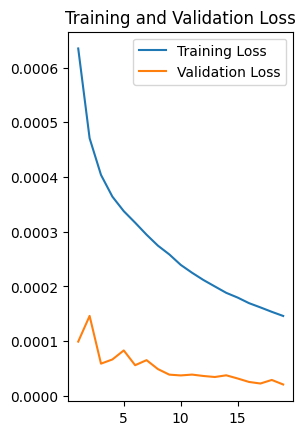

In [29]:
# visualise training loss/validation loss vs. epochs 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss[1:], label='Training Loss')
plt.plot(epochs_range, val_loss[1:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# save the model
model.save("../models/single_variable_LSTM1024_Dropout_Dense_lr_0.0001_ws8.keras")

In [31]:
# evaluate against evaluation data
eval_loss = model.evaluate(X_eval, y_eval)
print(f"Evaluation Loss: {eval_loss}")

1218/1218 [==============================] - 3s 2ms/step - loss: 2.0891e-05
Evaluation Loss: 2.0891151507385075e-05


## Test Model Against a Real Hurricane

In [32]:
def get_points_for_sid(df, sid):
    # Filter the DataFrame for the given SID
    filtered_df = df[df['SID'] == sid]
    # Extract the x, y, and z columns and convert them to a 2D NumPy array
    points_array = filtered_df[['x', 'y', 'z']].to_numpy()
    return points_array

In [33]:
sid = "1978279N14142"

In [34]:
test_hurricane = get_points_for_sid(simple_df,sid)

In [35]:
test_hurricane

array([[-0.76460347,  0.5973737 ,  0.2419219 ],
       [-0.75299451,  0.61194204,  0.2419219 ],
       [-0.7433951 ,  0.62157478,  0.24699901],
       [-0.73475381,  0.62976018,  0.25206936],
       [-0.72600369,  0.63780982,  0.25713279],
       [-0.71714701,  0.64572207,  0.26218918],
       [-0.70738559,  0.65504624,  0.26555612],
       [-0.69633489,  0.66543208,  0.26891982],
       [-0.68664032,  0.67475956,  0.27060045],
       [-0.67648374,  0.68360522,  0.27395922],
       [-0.66808165,  0.6918188 ,  0.27395922],
       [-0.66080044,  0.69877688,  0.27395922],
       [-0.65377065,  0.70600808,  0.27228025],
       [-0.64665987,  0.71316647,  0.27060045],
       [-0.63946888,  0.72025113,  0.26891982],
       [-0.63092819,  0.72836342,  0.26723838],
       [-0.62386588,  0.7356374 ,  0.26387305],
       [-0.61612824,  0.74213005,  0.26387305],
       [-0.6099187 ,  0.74783421,  0.26218918],
       [-0.60233868,  0.75453663,  0.26050451],
       [-0.59468332,  0.76115994,  0.258

In [233]:
def predict_path(model, initial_sequence, steps):
    path = []
    current_sequence = initial_sequence
    
    for _ in range(steps):
        # Predict the next point
        next_point = model.predict(np.expand_dims(current_sequence, axis=0))
        
        # Append the prediction to the path
        path.append(next_point[0])
        
        # Update the current sequence by appending the predicted point
        current_sequence = np.append(current_sequence[1:], next_point, axis=0)
    
    return np.array(path)

# Example: Predicting the next 35 steps from the first 5 sequence in the evaluation set
predicted_path = predict_path(model, test_hurricane[0:10], steps=40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7m

In [36]:
# visualise the performance of the model
def plot_predicted_vs_actual(actual_path, pred_path, start_index):
    # Calculate the end index based on the start index and the length of the predicted path
    end_index = start_index + len(pred_path)
    
    # Ensure the predicted path fits within the bounds of the actual path
    if end_index > len(actual_path):
        raise ValueError("Predicted path exceeds bounds of actual path. Adjust the start_index or predicted_path length.")
    
    plt.figure(figsize=(14, 6))

    # Plotting x-coordinate over time
    plt.subplot(1, 3, 1)
    plt.plot(range(len(actual_path)), actual_path[:, 0], label='Actual x', color='blue', marker='o')
    plt.plot(range(start_index, end_index), pred_path[:, 0], label='Predicted x', color='red', linestyle='--', marker='x')
    plt.xlabel('Time Step')
    plt.ylabel('x Coordinate')
    plt.title('Actual vs Predicted x')
    plt.legend()

    # Plotting y-coordinate over time
    plt.subplot(1, 3, 2)
    plt.plot(range(len(actual_path)), actual_path[:, 1], label='Actual y', color='blue', marker='o')
    plt.plot(range(start_index, end_index), pred_path[:, 1], label='Predicted y', color='red', linestyle='--', marker='x')
    plt.xlabel('Time Step')
    plt.ylabel('y Coordinate')
    plt.title('Actual vs Predicted y')
    plt.legend()

    # Plotting z-coordinate over time
    plt.subplot(1, 3, 3)
    plt.plot(range(len(actual_path)), actual_path[:, 2], label='Actual z', color='blue', marker='o')
    plt.plot(range(start_index, end_index), pred_path[:, 2], label='Predicted z', color='red', linestyle='--', marker='x')
    plt.xlabel('Time Step')
    plt.ylabel('z Coordinate')
    plt.title('Actual vs Predicted z')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_predicted_vs_actual(test_hurricane,predicted_path,10)

NameError: name 'predicted_path' is not defined

In [89]:
list_hurricanes = []

In [90]:
list_hurricanes.append(get_points_for_sid(simple_df,"1945271N06160"))

In [91]:
list_hurricanes.append(get_points_for_sid(simple_df,"1978252N17119"))

In [92]:
list_hurricanes

[array([[-0.93454489,  0.34014652,  0.10452846],
        [-0.93101558,  0.34809246,  0.10973431],
        [-0.92757924,  0.35606431,  0.11320321],
        [-0.92387255,  0.36392308,  0.11840397],
        [-0.92027277,  0.37181433,  0.12186934],
        [-0.91659447,  0.37966586,  0.12533323],
        [-0.91283812,  0.38747679,  0.1287956 ],
        [-0.90879113,  0.39515363,  0.13398619],
        [-0.9046549 ,  0.40277831,  0.1391731 ],
        [-0.898762  ,  0.41338433,  0.14608303],
        [-0.89196039,  0.42544328,  0.15298584],
        [-0.8859653 ,  0.43594897,  0.15815807],
        [-0.87878691,  0.44776429,  0.16504761],
        [-0.8711422 ,  0.45930118,  0.17364818],
        [-0.86328107,  0.47067612,  0.18223553],
        [-0.85520716,  0.48188447,  0.190809  ],
        [-0.84863969,  0.48996235,  0.19936793],
        [-0.84342069,  0.49681275,  0.20449605],
        [-0.83931413,  0.50231914,  0.20791169],
        [-0.83572986,  0.506136  ,  0.21303039],
        [-0.83242919

In [119]:
def evaluateModel(model, actual_hurricane_path, window_size):
    predicted_paths = []
    predicted_paths.append(predict_path(model, actual_hurricane_path[0:window_size], steps=len(actual_hurricane_path)-window_size))
    return predicted_paths

In [129]:
SID_list = ["1945271N06160","1978252N17119", "1978279N14142"]

In [130]:
def totalMSE(model,window_size,SID_list,df):
    mse = []
    for sid in SID_list:
        actual_path = get_points_for_sid(df,sid)
        pred_path = evaluateModel(model,actual_path,window_size)
        mse.append(np.mean((pred_path - actual_path[window_size:]) ** 2))
    return mse

In [131]:
mseList = totalMSE(model,5,SID_list,simple_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

In [136]:
def averageMSE(mseList):
    n = len(mseList)
    total = 0
    for elem in mseList:
        total += elem
    return total/n

In [137]:
averageMSE(mseList) # very large error

0.04950618834478959